### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
import sys
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv(r"Data/max_planck_weather_ts.csv")
# current_db = current_db.reset_index()
current_db['Date Time'] = pd.to_datetime(current_db['Date Time'])

# Index_col = "fecha_completa"
# target_col = "md_espana"

# current_db = current_db.reset_index(drop=True)

In [4]:
current_db.columns = ['fecha_completa', 'presion', 'temperatura', 'temperaturaK', 'temperaturaDew', 'humedad_relativa', 'VPmax', 'VPact', 'VPdef', 'humedad_especifica', 'concentracion_vapor_agua', 'rho', 'velocidad_viento', 'max_valocidad_viento', 'direccion_viento']

In [5]:
current_db

,fecha_completa,presion,temperatura,temperaturaK,temperaturaDew,humedad_relativa,VPmax,VPact,VPdef,humedad_especifica,concentracion_vapor_agua,rho,velocidad_viento,max_valocidad_viento,direccion_viento
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,2016-12-31 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [6]:
current_db = current_db[~current_db.duplicated()]

In [7]:
current_db['hora'] = current_db.fecha_completa.dt.hour
current_db['mes'] = current_db.fecha_completa.dt.month

In [8]:
current_db = current_db[(current_db.fecha_completa.dt.minute == 0)]
current_db = current_db.drop('temperaturaK', axis = 1)
current_db = current_db.reset_index(drop=True)

In [9]:
current_db

,fecha_completa,presion,temperatura,temperaturaDew,humedad_relativa,VPmax,VPact,VPdef,humedad_especifica,concentracion_vapor_agua,rho,velocidad_viento,max_valocidad_viento,direccion_viento,hora,mes
0,2009-01-01 01:00:00,996.50,-8.05,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70,1,1
1,2009-01-01 02:00:00,996.62,-8.88,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30,2,1
2,2009-01-01 03:00:00,996.84,-8.81,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20,3,1
3,2009-01-01 04:00:00,996.99,-9.05,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00,4,1
4,2009-01-01 05:00:00,997.46,-9.63,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70032,2016-12-31 20:00:00,1001.47,-1.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00,20,12
70033,2016-12-31 21:00:00,1001.29,-3.09,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50,21,12
70034,2016-12-31 22:00:00,1000.70,-2.59,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15,22,12
70035,2016-12-31 23:00:00,1000.21,-3.76,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70,23,12


In [10]:
lags = sorted(([24, 48, 72, 96, 120, 144, 168])*len(current_db.columns))

In [11]:
for col, lag in list(zip(list(current_db.columns)*6, lags)):
    if col not in ['fecha_completa', 'hora', 'mes']:
        current_db[col+"_"+str(lag)] = current_db[col].shift(lag)

In [12]:
current_db = current_db.dropna()

In [14]:
current_db.drop(['temperatura', 'presion', 'temperaturaDew', 'humedad_relativa', 'VPmax', 'VPact', 'VPdef', 'humedad_especifica', 'concentracion_vapor_agua', 'rho', 'max_valocidad_viento', 'direccion_viento'],
                axis = 1)

,fecha_completa,velocidad_viento,hora,mes,presion_24,temperatura_24,temperaturaDew_24,humedad_relativa_24,VPmax_24,VPact_24,...,humedad_relativa_144,VPmax_144,VPact_144,VPdef_144,humedad_especifica_144,concentracion_vapor_agua_144,rho_144,velocidad_viento_144,max_valocidad_viento_144,direccion_viento_144
144,2009-07-01 01:00:00,0.68,1,7,997.71,-13.34,-15.46,83.9,2.18,1.83,...,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
145,2009-07-01 02:00:00,0.38,2,7,997.96,-13.64,-15.63,84.8,2.12,1.80,...,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
146,2009-07-01 03:00:00,1.83,3,7,998.22,-13.89,-15.80,85.3,2.08,1.77,...,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
147,2009-07-01 04:00:00,1.10,4,7,998.24,-14.29,-16.03,86.5,2.01,1.74,...,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
148,2009-07-01 05:00:00,0.70,5,7,998.14,-15.13,-16.75,87.3,1.88,1.64,...,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70032,2016-12-31 20:00:00,1.24,20,12,1008.99,-1.80,-2.78,93.0,5.35,4.98,...,80.5,11.81,9.51,2.30,5.96,9.54,1223.53,1.93,4.65,224.3
70033,2016-12-31 21:00:00,0.61,21,12,1009.24,-2.21,-3.75,89.1,5.19,4.62,...,82.1,11.60,9.53,2.08,5.97,9.56,1224.99,1.91,4.18,342.9
70034,2016-12-31 22:00:00,0.38,22,12,1008.93,-2.63,-4.99,83.7,5.03,4.21,...,83.0,11.38,9.44,1.93,5.91,9.47,1227.02,2.58,6.25,236.7
70035,2016-12-31 23:00:00,0.89,23,12,1008.82,-2.98,-4.85,86.9,4.90,4.26,...,82.1,11.35,9.32,2.03,5.83,9.34,1227.50,2.80,4.61,239.6


In [15]:
current_db = current_db.sort_values('fecha_completa')

In [16]:
current_db = current_db.reset_index(drop=True)

In [17]:
Index_col = "fecha_completa"
target_col = "velocidad_viento"

In [18]:
current_db.fecha_completa[current_db.fecha_completa.duplicated()]

Series([], Name: fecha_completa, dtype: datetime64[ns])

In [19]:
current_db.velocidad_viento.sort_values()

57066   -9999.00
57064   -9999.00
57065   -9999.00
631         0.00
6282        0.00
          ...   
57354      12.05
45586      12.21
10022      12.37
42131      12.49
27591      12.58
Name: velocidad_viento, Length: 69893, dtype: float64

In [20]:
current_db = current_db[current_db.velocidad_viento >= 0]

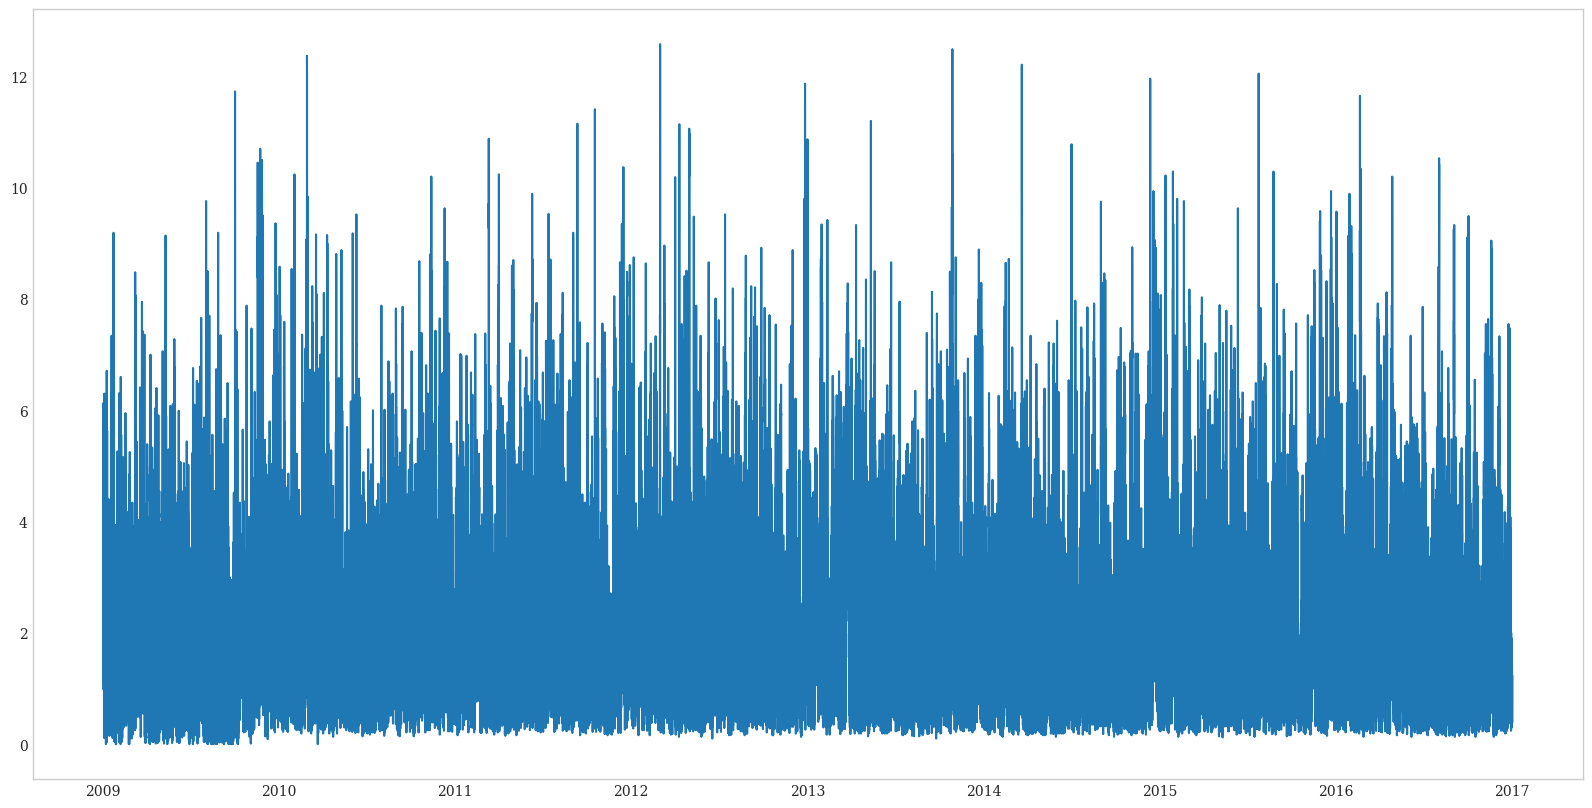

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db.fecha_completa, current_db.velocidad_viento)
ax.grid()

In [23]:
current_db_train = current_db[current_db.fecha_completa.dt.year < 2015]
current_db_val = current_db[current_db.fecha_completa.dt.year == 2015]
current_db_test = current_db[current_db.fecha_completa.dt.year == 2016]

train_idx = current_db_train[Index_col].unique()
val_idx = current_db_val[Index_col].unique()
test_idx = current_db_test[Index_col].unique()

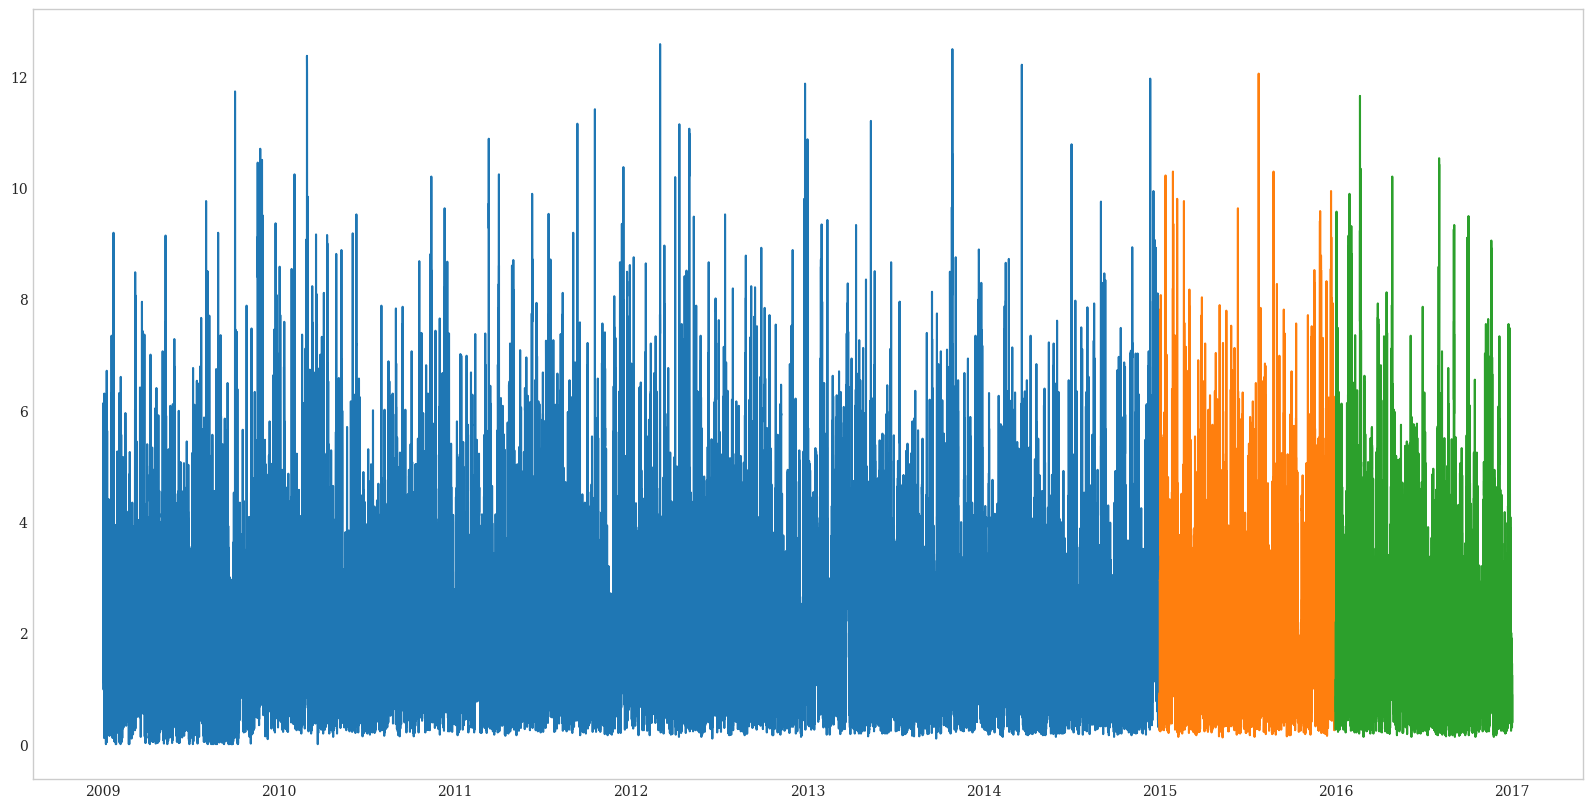

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db_train.fecha_completa, current_db_train.velocidad_viento)
ax.plot(current_db_val.fecha_completa, current_db_val.velocidad_viento)
ax.plot(current_db_test.fecha_completa, current_db_test.velocidad_viento)
ax.grid()

In [25]:
selected_features = list(current_db.columns)
selected_features.remove('fecha_completa')
selected_features.remove('temperatura')
selected_features.remove('presion')
selected_features.remove('temperaturaDew')
selected_features.remove('humedad_relativa')
selected_features.remove('VPmax')
selected_features.remove('VPact')
selected_features.remove('VPdef')
selected_features.remove('humedad_especifica')
selected_features.remove('concentracion_vapor_agua')
selected_features.remove('rho')
selected_features.remove('velocidad_viento')
selected_features.remove('direccion_viento')
selected_features.remove('max_valocidad_viento')

In [26]:
selected_features

['hora',
 'mes',
 'presion_24',
 'temperatura_24',
 'temperaturaDew_24',
 'humedad_relativa_24',
 'VPmax_24',
 'VPact_24',
 'VPdef_24',
 'humedad_especifica_24',
 'concentracion_vapor_agua_24',
 'rho_24',
 'velocidad_viento_24',
 'max_valocidad_viento_24',
 'direccion_viento_24',
 'presion_48',
 'temperatura_48',
 'temperaturaDew_48',
 'humedad_relativa_48',
 'VPmax_48',
 'VPact_48',
 'VPdef_48',
 'humedad_especifica_48',
 'concentracion_vapor_agua_48',
 'rho_48',
 'velocidad_viento_48',
 'max_valocidad_viento_48',
 'direccion_viento_48',
 'presion_72',
 'temperatura_72',
 'temperaturaDew_72',
 'humedad_relativa_72',
 'VPmax_72',
 'VPact_72',
 'VPdef_72',
 'humedad_especifica_72',
 'concentracion_vapor_agua_72',
 'rho_72',
 'velocidad_viento_72',
 'max_valocidad_viento_72',
 'direccion_viento_72',
 'presion_96',
 'temperatura_96',
 'temperaturaDew_96',
 'humedad_relativa_96',
 'VPmax_96',
 'VPact_96',
 'VPdef_96',
 'humedad_especifica_96',
 'concentracion_vapor_agua_96',
 'rho_96',
 'v

In [27]:
X_train = current_db_train[selected_features]
y_train = current_db_train[target_col]

X_val = current_db_val[selected_features]
y_val = current_db_val[target_col]

X_test = current_db_test[selected_features]
y_test = current_db_test[target_col]

In [28]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [29]:
current_db_train_val = current_db_train.append(current_db_val)

In [30]:
seeds = np.random.randint(1, 999999, 50)

In [31]:
scaler = MinMaxScaler()
scaler_obj = MinMaxScaler()
scaler.fit(X_train)
scaler_obj.fit(y_train.to_numpy().reshape(-1, 1))

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

y_train_norm = scaler_obj.transform(y_train.to_numpy().reshape(-1, 1)).reshape(len(y_train))
y_val_norm = scaler_obj.transform(y_val.to_numpy().reshape(-1, 1)).reshape(len(y_val))
y_test_norm = scaler_obj.transform(y_test.to_numpy().reshape(-1, 1)).reshape(len(y_test))

## Lasso 0.01

In [32]:
model = Lasso(alpha = 0.01)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.01)

In [33]:
features_lasso_001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_001

[]

In [34]:
# dict_results_lasso_001 = {'rmse':[], 'mae':[], 'r2':[]}

In [35]:
# X_test_lasso_001 = X_test[features_lasso_001]
# X_train_lasso_001= X_train[features_lasso_001]
# X_val_lasso_001 = X_val[features_lasso_001]
# for iteration in range(50):
#     print(iteration)
#     model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
#     model.fit(
#         X_train_lasso_001, y_train,
#         eval_set=(X_val_lasso_001, y_val),
#         verbose = 0,
#         plot=False
#     );
    
#     test_results = scores_calc_print(y_test, model.predict(X_test_lasso_001), print_bool=False)
    
#     dict_results_lasso_001["r2"].append(test_results["R2"])
#     dict_results_lasso_001["rmse"].append(test_results["RMSE"])
#     dict_results_lasso_001["mae"].append(test_results["MAE"])

In [36]:
# results_lasso_001_df = pd.DataFrame(dict_results_lasso_001)
# mean_lasso_001_test = results_lasso_001_df.mean()
# std_lasso_001_test = results_lasso_001_df.std()
# max_lasso_001_test = results_lasso_001_df.max()
# min_lasso_001_test = results_lasso_001_df.min()

In [37]:
# mean_lasso_001_test, std_lasso_001_test, max_lasso_001_test, min_lasso_001_test

## Lasso 0.001

In [38]:
model = Lasso(alpha = 0.001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.001)

In [39]:
features_lasso_0001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_0001

['VPact_144',
 'VPact_72',
 'hora',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_72',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_24',
 'max_valocidad_viento_48',
 'velocidad_viento_144',
 'velocidad_viento_24',
 'velocidad_viento_48',
 'velocidad_viento_96']

In [40]:
dict_results_lasso_0001 = {'rmse':[], 'mae':[], 'r2':[]}

In [41]:
X_test_lasso_0001 = X_test[features_lasso_0001]
X_train_lasso_0001= X_train[features_lasso_0001]
X_val_lasso_0001 = X_val[features_lasso_0001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_0001, y_train,
        eval_set=(X_val_lasso_0001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_0001), print_bool=False)
    
    dict_results_lasso_0001["r2"].append(test_results["R2"])
    dict_results_lasso_0001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_0001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [42]:
results_lasso_0001_df = pd.DataFrame(dict_results_lasso_0001)
mean_lasso_0001_test = results_lasso_0001_df.mean()
std_lasso_0001_test = results_lasso_0001_df.std()
max_lasso_0001_test = results_lasso_0001_df.max()
min_lasso_0001_test = results_lasso_0001_df.min()

In [43]:
mean_lasso_0001_test, std_lasso_0001_test, max_lasso_0001_test, min_lasso_0001_test

(rmse    1.394337
 mae     1.042243
 r2      0.176927
 dtype: float64,
 rmse    0.001327
 mae     0.001438
 r2      0.001566
 dtype: float64,
 rmse    1.396986
 mae     1.045980
 r2      0.180350
 dtype: float64,
 rmse    1.391436
 mae     1.039115
 r2      0.173798
 dtype: float64)

## Lasso 0.0001

In [44]:
model = Lasso(alpha = 0.0001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.0001)

In [45]:
features_lasso_00001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_00001

['VPact_120',
 'VPact_72',
 'VPact_96',
 'VPdef_120',
 'VPdef_96',
 'concentracion_vapor_agua_144',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_144',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_24',
 'max_valocidad_viento_48',
 'max_valocidad_viento_72',
 'max_valocidad_viento_96',
 'mes',
 'presion_24',
 'presion_72',
 'presion_96',
 'temperaturaDew_24',
 'temperaturaDew_72',
 'velocidad_viento_48']

In [46]:
dict_results_lasso_00001 = {'rmse':[], 'mae':[], 'r2':[]}

In [47]:
X_test_lasso_00001 = X_test[features_lasso_00001]
X_train_lasso_00001= X_train[features_lasso_00001]
X_val_lasso_00001 = X_val[features_lasso_00001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_00001, y_train,
        eval_set=(X_val_lasso_00001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_00001), print_bool=False)
    
    dict_results_lasso_00001["r2"].append(test_results["R2"])
    dict_results_lasso_00001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_00001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [48]:
results_lasso_00001_df = pd.DataFrame(dict_results_lasso_00001)
mean_lasso_00001_test = results_lasso_00001_df.mean()
std_lasso_00001_test = results_lasso_00001_df.std()
max_lasso_00001_test = results_lasso_00001_df.max()
min_lasso_00001_test = results_lasso_00001_df.min()

In [49]:
mean_lasso_00001_test, std_lasso_00001_test, max_lasso_00001_test, min_lasso_00001_test

(rmse    1.399224
 mae     1.042222
 r2      0.171144
 dtype: float64,
 rmse    0.003502
 mae     0.002283
 r2      0.004157
 dtype: float64,
 rmse    1.413060
 mae     1.048650
 r2      0.178446
 dtype: float64,
 rmse    1.393051
 mae     1.037793
 r2      0.154675
 dtype: float64)

## Lasso 0.00001

In [50]:
model = Lasso(alpha = 0.00001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=1e-05)

In [51]:
features_lasso_000001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_000001

['VPact_120',
 'VPact_144',
 'VPact_96',
 'VPdef_120',
 'VPdef_144',
 'VPdef_24',
 'VPdef_72',
 'VPdef_96',
 'concentracion_vapor_agua_120',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_72',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'humedad_relativa_96',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_24',
 'max_valocidad_viento_48',
 'max_valocidad_viento_72',
 'max_valocidad_viento_96',
 'mes',
 'presion_144',
 'presion_24',
 'presion_48',
 'presion_72',
 'presion_96',
 'temperaturaDew_120',
 'temperaturaDew_144',
 'temperaturaDew_24',
 'temperaturaDew_96',
 'temperatura_120',
 'temperatura_48',
 'temperatura_72',
 'velocidad_viento_120',
 'velocidad_viento_48']

In [52]:
dict_results_lasso_000001 = {'rmse':[], 'mae':[], 'r2':[]}

In [53]:
X_test_lasso_000001 = X_test[features_lasso_000001]
X_train_lasso_000001= X_train[features_lasso_000001]
X_val_lasso_000001 = X_val[features_lasso_000001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_000001, y_train,
        eval_set=(X_val_lasso_000001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_000001), print_bool=False)
    
    dict_results_lasso_000001["r2"].append(test_results["R2"])
    dict_results_lasso_000001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_000001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [54]:
results_lasso_000001_df = pd.DataFrame(dict_results_lasso_000001)
mean_lasso_000001_test = results_lasso_000001_df.mean()
std_lasso_000001_test = results_lasso_000001_df.std()
max_lasso_000001_test = results_lasso_000001_df.max()
min_lasso_000001_test = results_lasso_000001_df.min()

In [55]:
mean_lasso_000001_test, std_lasso_000001_test, max_lasso_000001_test, min_lasso_000001_test

(rmse    1.399191
 mae     1.041702
 r2      0.171185
 dtype: float64,
 rmse    0.002739
 mae     0.002248
 r2      0.003249
 dtype: float64,
 rmse    1.407569
 mae     1.047248
 r2      0.175367
 dtype: float64,
 rmse    1.395659
 mae     1.037737
 r2      0.161233
 dtype: float64)

## Boruta

In [56]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='gini',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)

# 1 minutos 46 segundos

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:16<00:00, 24.80s/it]

48 attributes confirmed important: ['direccion_viento_48', 'humedad_relativa_48', 'presion_144', 'direccion_viento_144', 'VPact_24', 'rho_48', 'max_valocidad_viento_24', 'presion_72', 'rho_72', 'rho_24', 'hora', 'humedad_relativa_120', 'rho_120', 'max_valocidad_viento_120', 'max_valocidad_viento_48', 'velocidad_viento_24', 'VPmax_72', 'temperaturaDew_120', 'presion_48', 'temperaturaDew_48', 'humedad_relativa_144', 'VPdef_144', 'humedad_especifica_24', 'humedad_relativa_24', 'humedad_especifica_48', 'concentracion_vapor_agua_24', 'mes', 'rho_144', 'direccion_viento_96', 'concentracion_vapor_agua_96', 'temperatura_120', 'VPact_48', 'concentracion_vapor_agua_120', 'velocidad_viento_120', 'humedad_relativa_72', 'direccion_viento_120', 'VPact_72', 'concentracion_vapor_agua_72', 'VPdef_72', 'presion_24', 'temperaturaDew_24', 'presion_120', 'presion_96', 'VPdef_24', 'rho_96', 'velocidad_viento_48', 'direccion_viento_24', 'VPdef_48']
1 attributes confirmed unimportant: ['temperatura_72']
31 te

In [57]:
subset = Feature_Selector.Subset()
selected_features_boruta = sorted(subset.columns.values)
selected_features_boruta

['VPact_24',
 'VPact_48',
 'VPact_72',
 'VPdef_144',
 'VPdef_24',
 'VPdef_48',
 'VPdef_72',
 'VPmax_72',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_72',
 'concentracion_vapor_agua_96',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'max_valocidad_viento_120',
 'max_valocidad_viento_24',
 'max_valocidad_viento_48',
 'mes',
 'presion_120',
 'presion_144',
 'presion_24',
 'presion_48',
 'presion_72',
 'presion_96',
 'rho_120',
 'rho_144',
 'rho_24',
 'rho_48',
 'rho_72',
 'rho_96',
 'temperaturaDew_120',
 'temperaturaDew_24',
 'temperaturaDew_48',
 'temperatura_120',
 'velocidad_viento_120',
 'velocidad_viento_24',
 'velocidad_viento_48']

In [58]:
dict_results_boruta = {'rmse':[], 'mae':[], 'r2':[]}

In [59]:
X_test_boruta = X_test[selected_features_boruta]
X_train_boruta = X_train[selected_features_boruta]
X_val_boruta = X_val[selected_features_boruta]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_boruta, y_train,
        eval_set=(X_val_boruta, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_boruta), print_bool=False)
    
    dict_results_boruta["r2"].append(test_results["R2"])
    dict_results_boruta["rmse"].append(test_results["RMSE"])
    dict_results_boruta["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [60]:
results_boruta_df = pd.DataFrame(dict_results_boruta)
mean_boruta_test = results_boruta_df.mean()
std_boruta_test = results_boruta_df.std()
max_boruta_test = results_boruta_df.max()
min_boruta_test = results_boruta_df.min()

In [61]:
mean_boruta_test, std_boruta_test, max_boruta_test, min_boruta_test

(rmse    1.401415
 mae     1.043805
 r2      0.168549
 dtype: float64,
 rmse    0.002263
 mae     0.003309
 r2      0.002684
 dtype: float64,
 rmse    1.406657
 mae     1.050983
 r2      0.176181
 dtype: float64,
 rmse    1.39497
 mae     1.03719
 r2      0.16232
 dtype: float64)

## PIMP

In [62]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
model = model.fit(
    X_train, y_train,
    verbose = 0,
    plot=False
)

In [63]:
pimp = PermutationImportance(model, cv='prefit').fit(X_val, y_val)

In [64]:
pimp.feature_importances_

array([ 7.87239975e-02, -1.33988296e-03,  8.21719574e-03,  3.14812638e-03,
        9.91459017e-05,  4.83681562e-03,  1.73804639e-03,  1.58666937e-02,
        2.92051205e-03,  4.12972268e-03,  7.17771963e-03,  3.09576334e-03,
        3.91355293e-03,  7.31385562e-02,  1.79105645e-03,  1.66037348e-02,
        7.34937950e-03,  1.86759094e-02, -2.36009800e-04,  3.49649545e-03,
        2.99315909e-03, -2.95059451e-03,  2.43913028e-02,  9.81197541e-03,
        7.56746984e-03,  1.37036003e-03,  2.22588598e-03,  3.60410780e-03,
        1.62927743e-02,  5.20791391e-04,  7.64818634e-03, -1.46089160e-03,
        2.87635551e-02,  2.01010206e-02, -4.57014568e-04,  4.74877291e-03,
        5.68444905e-04,  5.56237971e-03,  2.34024964e-05, -7.57814901e-04,
       -2.91640263e-05, -2.68446272e-04,  3.05305956e-03,  2.27607477e-03,
       -3.02938676e-04, -6.99576652e-05,  5.32502187e-04, -4.92423589e-04,
        1.22108643e-03,  1.09402249e-03,  1.09908554e-02,  2.61851420e-04,
       -3.85619999e-04, -

In [65]:
sel = SelectFromModel(pimp,threshold=None, prefit=True)

In [66]:
sel.transform(X_train).shape

(52422, 18)

In [67]:
selected_features_pimp = sorted(list(X_train.columns[sel.get_support()]))
selected_features_pimp

['VPact_24',
 'VPact_72',
 'VPmax_72',
 'concentracion_vapor_agua_144',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_48',
 'hora',
 'humedad_especifica_48',
 'max_valocidad_viento_24',
 'presion_24',
 'presion_48',
 'presion_72',
 'rho_48',
 'rho_96',
 'temperaturaDew_144',
 'temperaturaDew_48',
 'temperaturaDew_72',
 'temperatura_48']

In [68]:
dict_results_pimp = {'rmse':[], 'mae':[], 'r2':[]}

In [69]:
X_test_pimp = X_test[selected_features_pimp]
X_train_pimp = X_train[selected_features_pimp]
X_val_pimp = X_val[selected_features_pimp]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_pimp, y_train,
        eval_set=(X_val_pimp, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_pimp), print_bool=False)
    
    dict_results_pimp["r2"].append(test_results["R2"])
    dict_results_pimp["rmse"].append(test_results["RMSE"])
    dict_results_pimp["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [70]:
results_pimp_df = pd.DataFrame(dict_results_pimp)
mean_pimp_test = results_pimp_df.mean()
std_pimp_test = results_pimp_df.std()
max_pimp_test = results_pimp_df.max()
min_pimp_test = results_pimp_df.min()

In [71]:
mean_pimp_test, std_pimp_test, max_pimp_test, min_pimp_test

(rmse    1.406439
 mae     1.045242
 r2      0.162557
 dtype: float64,
 rmse    0.007341
 mae     0.003848
 r2      0.008783
 dtype: float64,
 rmse    1.435925
 mae     1.060802
 r2      0.174084
 dtype: float64,
 rmse    1.396744
 mae     1.040274
 r2      0.127097
 dtype: float64)

# Results

In [72]:
nombres = ['Lasso_0.001', 'Lasso_0.0001', 'Lasso_0.00001', 'Boruta', 'PIMP']

## MAE

In [73]:
resultados_mae_mean = [mean_lasso_0001_test['mae'], mean_lasso_00001_test['mae'], mean_lasso_000001_test['mae'], mean_boruta_test['mae'], mean_pimp_test['mae']]
resultados_mae_std = [std_lasso_0001_test['mae'], std_lasso_00001_test['mae'], std_lasso_000001_test['mae'], std_boruta_test['mae'], std_pimp_test['mae']]
resultados_mae_max = [max_lasso_0001_test['mae'], max_lasso_00001_test['mae'], max_lasso_000001_test['mae'], max_boruta_test['mae'], max_pimp_test['mae']]
resultados_mae_min = [min_lasso_0001_test['mae'], min_lasso_00001_test['mae'], min_lasso_000001_test['mae'], min_boruta_test['mae'], min_pimp_test['mae']]

(1.02, 1.07)

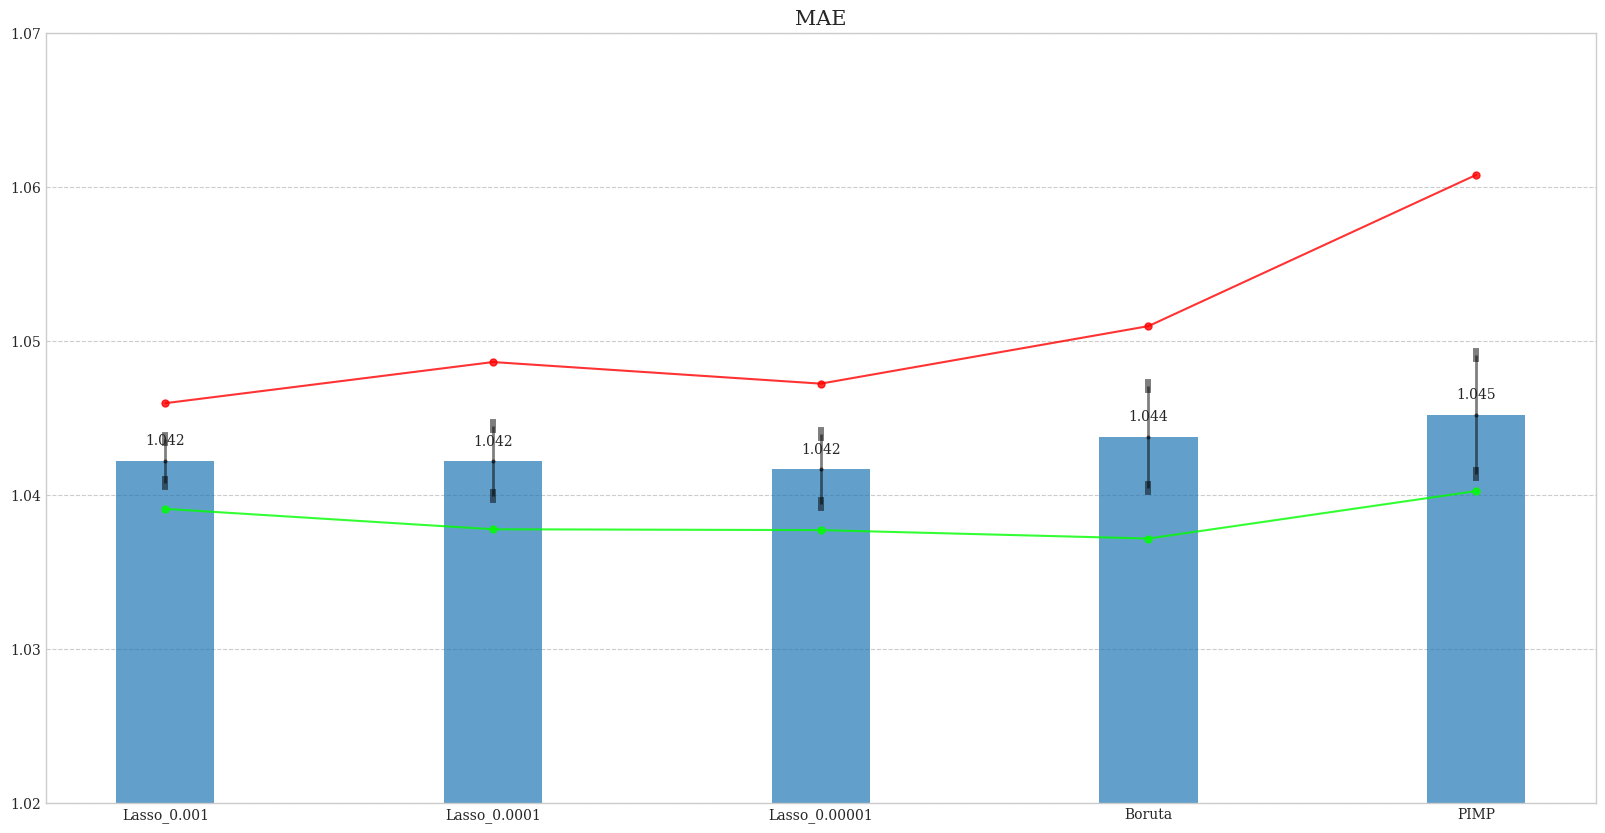

In [82]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([1.02, 1.07])


## RMSE

In [75]:
resultados_rmse_mean = [mean_lasso_0001_test['rmse'], mean_lasso_00001_test['rmse'], mean_lasso_000001_test['rmse'], mean_boruta_test['rmse'], mean_pimp_test['rmse']]
resultados_rmse_std = [std_lasso_0001_test['rmse'], std_lasso_00001_test['rmse'], std_lasso_000001_test['rmse'], std_boruta_test['rmse'], std_pimp_test['rmse']]
resultados_rmse_max = [max_lasso_0001_test['rmse'], max_lasso_00001_test['rmse'], max_lasso_000001_test['rmse'], max_boruta_test['rmse'], max_pimp_test['rmse']]
resultados_rmse_min = [min_lasso_0001_test['rmse'], min_lasso_00001_test['rmse'], min_lasso_000001_test['rmse'], min_boruta_test['rmse'], min_pimp_test['rmse']]

(1.38, 1.44)

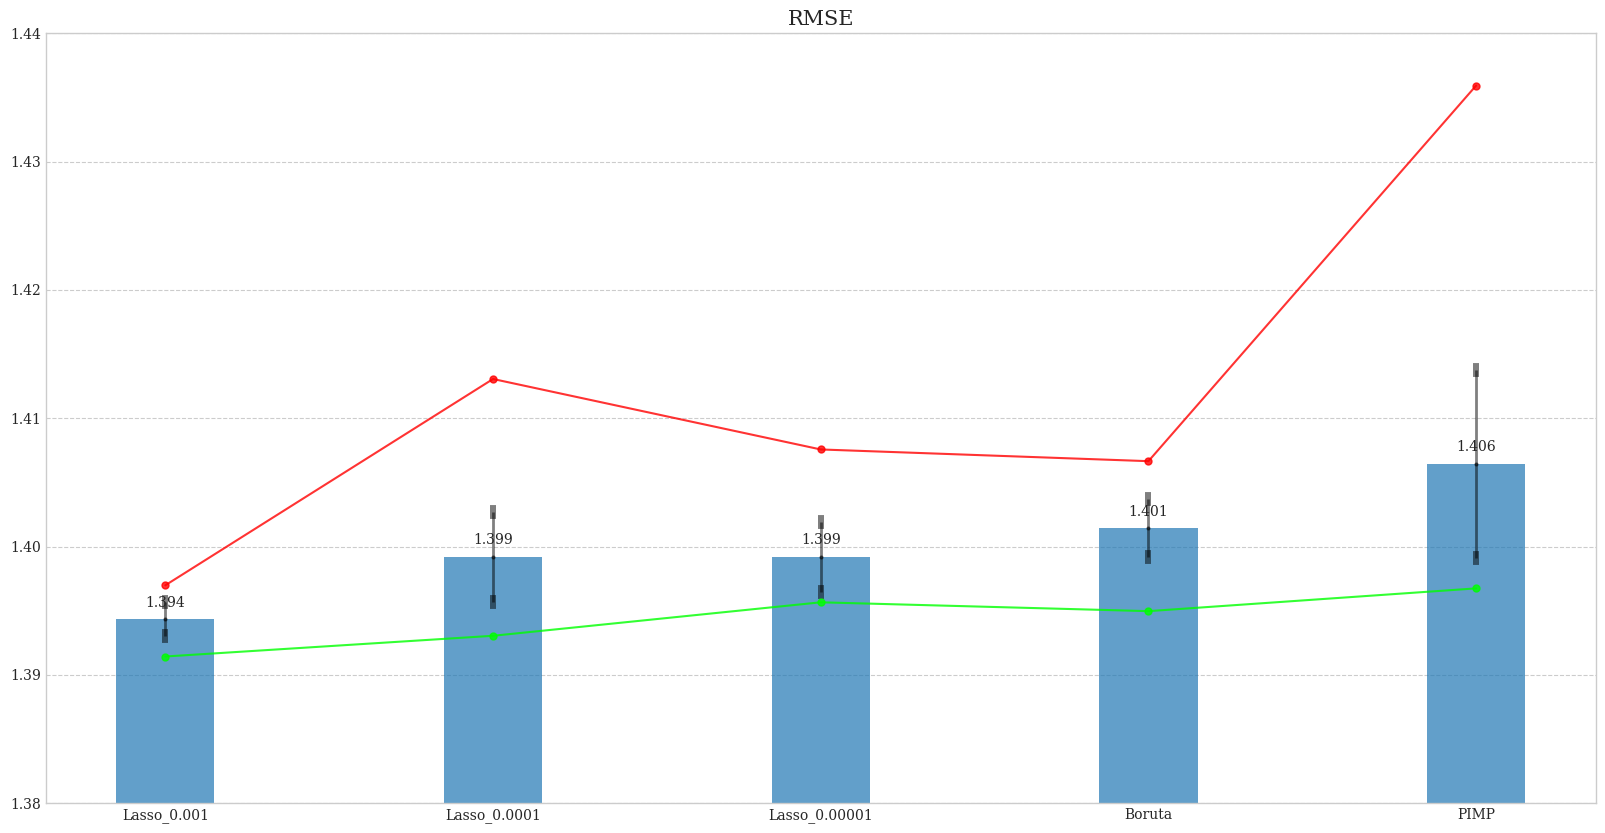

In [85]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([1.38, 1.44])

## R2

In [77]:
resultados_r2_mean = [mean_lasso_0001_test['r2'], mean_lasso_00001_test['r2'], mean_lasso_000001_test['r2'], mean_boruta_test['r2'], mean_pimp_test['r2']]
resultados_r2_std = [std_lasso_0001_test['r2'], std_lasso_00001_test['r2'], std_lasso_000001_test['r2'], std_boruta_test['r2'], std_pimp_test['r2']]
resultados_r2_max = [max_lasso_0001_test['r2'], max_lasso_00001_test['r2'], max_lasso_000001_test['r2'], max_boruta_test['r2'], max_pimp_test['r2']]
resultados_r2_min = [min_lasso_0001_test['r2'], min_lasso_00001_test['r2'], min_lasso_000001_test['r2'], min_boruta_test['r2'], min_pimp_test['r2']]

In [78]:
resultados_r2_max, resultados_r2_min

([0.18034979849744304,
  0.17844635829926037,
  0.17536719863187222,
  0.17618081071336977,
  0.17408414933067073],
 [0.17379797924972784,
  0.15467549221963506,
  0.16123265551084087,
  0.16231982882030294,
  0.12709740094272115])

(0.12, 0.19)

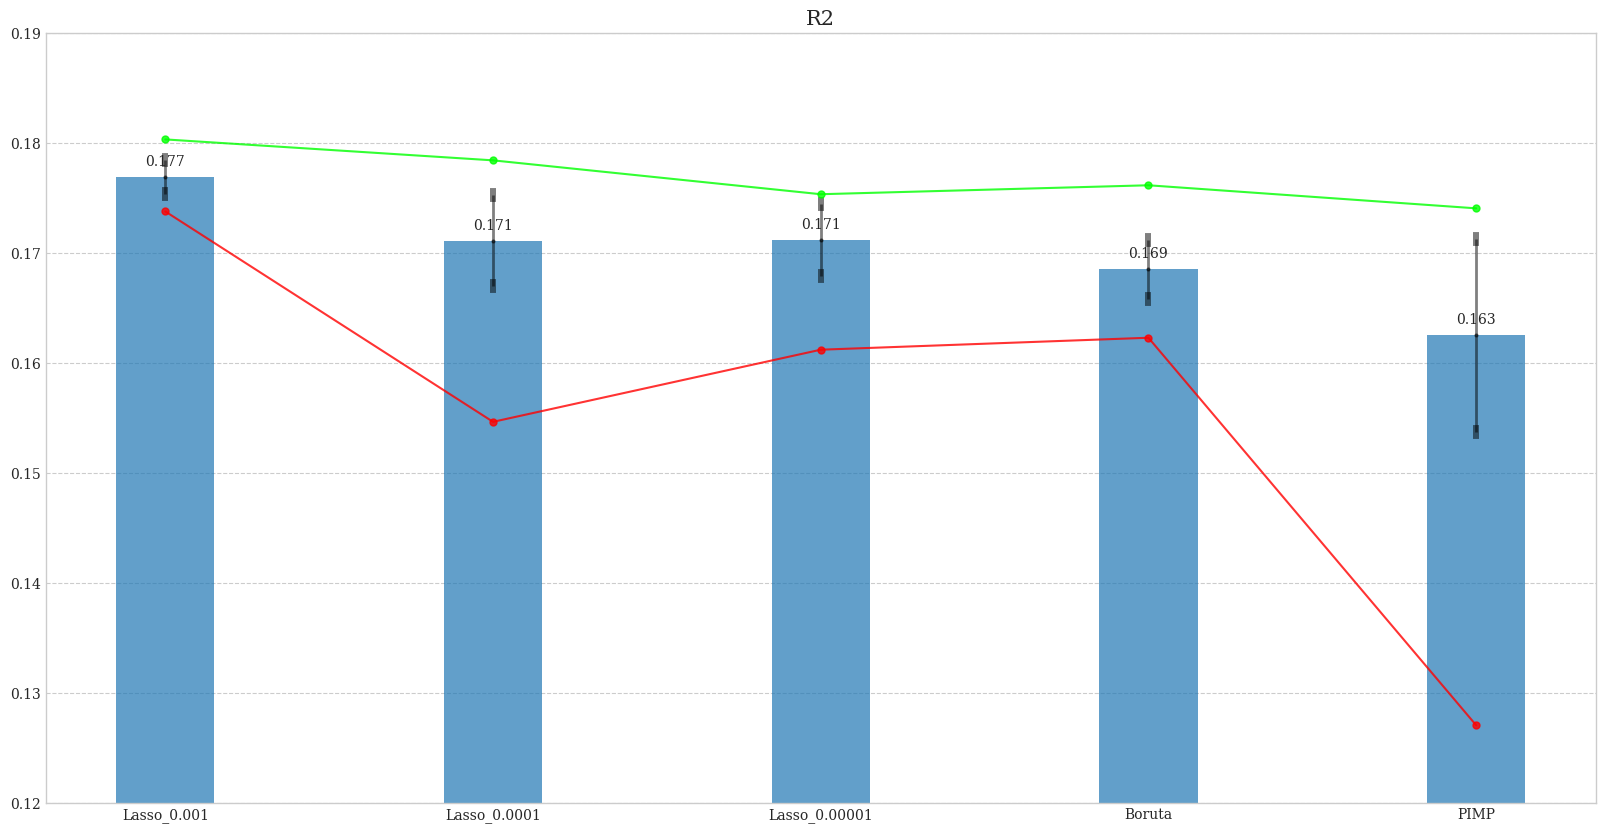

In [86]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0.12, 0.19])

## Number of variables

In [80]:
n_var = [len(features_lasso_0001), len(features_lasso_00001), len(features_lasso_000001), len(selected_features_boruta), len(selected_features_pimp)]

(0.0, 60.0)

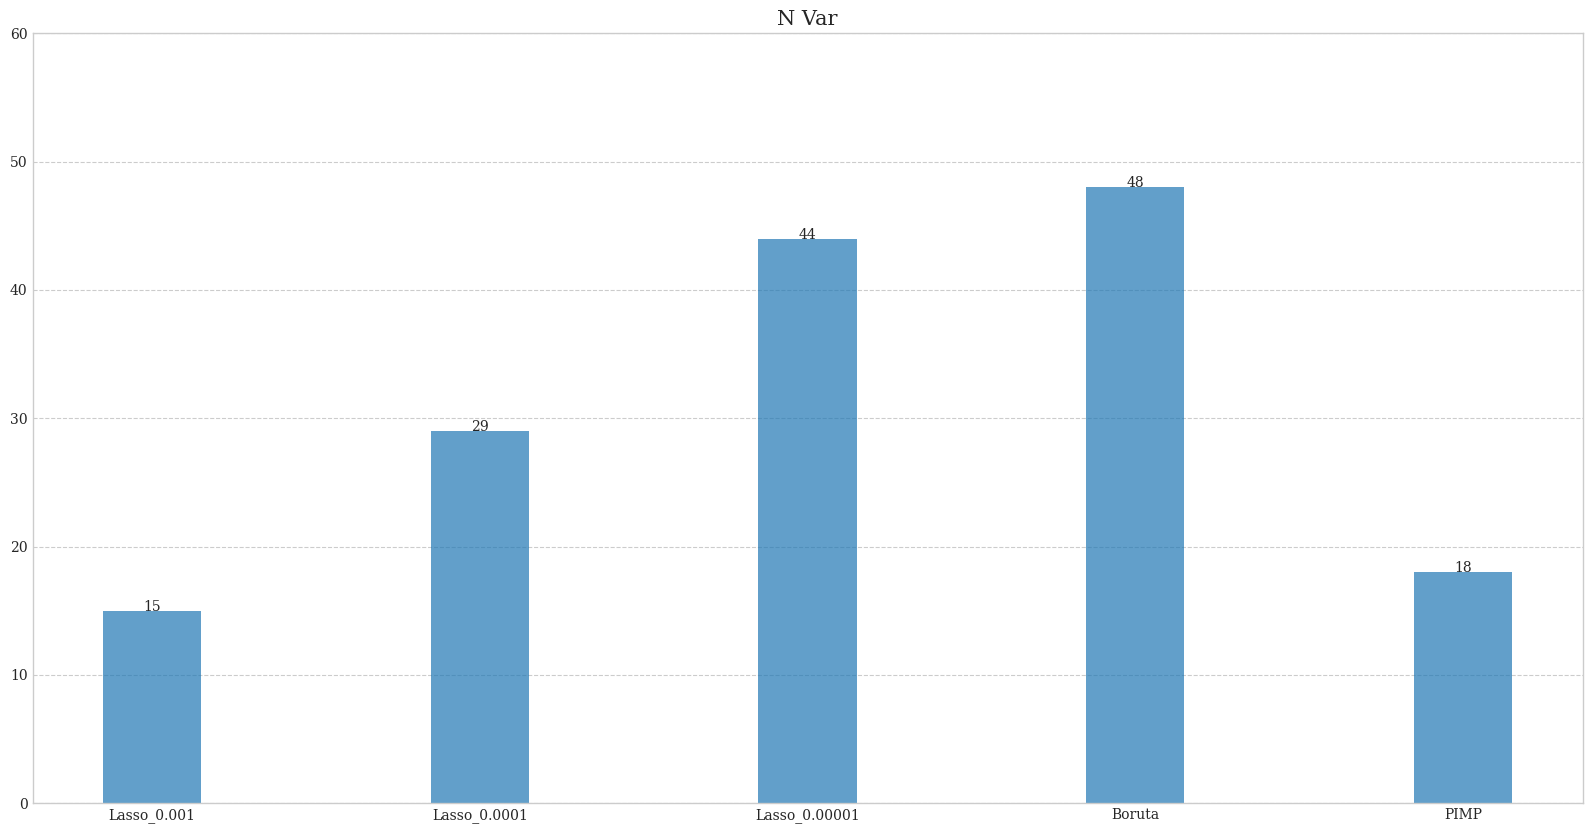

In [81]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 60])